## Gerando dados sintéticos a partir da adição de ruído Gaussiano

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_ = torch.load('../data/processed/X_.pt')
y_ = torch.load('../data/processed/y_.pt')

noise = np.random.normal(0,1,(5184, 22, 1125))
fake_X_ = X_ + noise

fake_X_ = torch.as_tensor(fake_X_).float()

real_set = TensorDataset(X_, y_)
fake_set = TensorDataset(fake_X_, y_)

print(X_.shape)
print(y_.shape)

/home/matias/Mestrado/venv_BCI/venv_BCI/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([5184, 22, 1125])
torch.Size([5184])


In [2]:
import numpy as np
from scipy import signal

window_size = 128
overlap = 64
fft_size = 128
sampling_rate = 250

spectrograms_spectrogram = []

for i in range(X_.shape[0]):
    f, t, spectrogram = signal.spectrogram(X_[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(5184, 22, 65, 16)


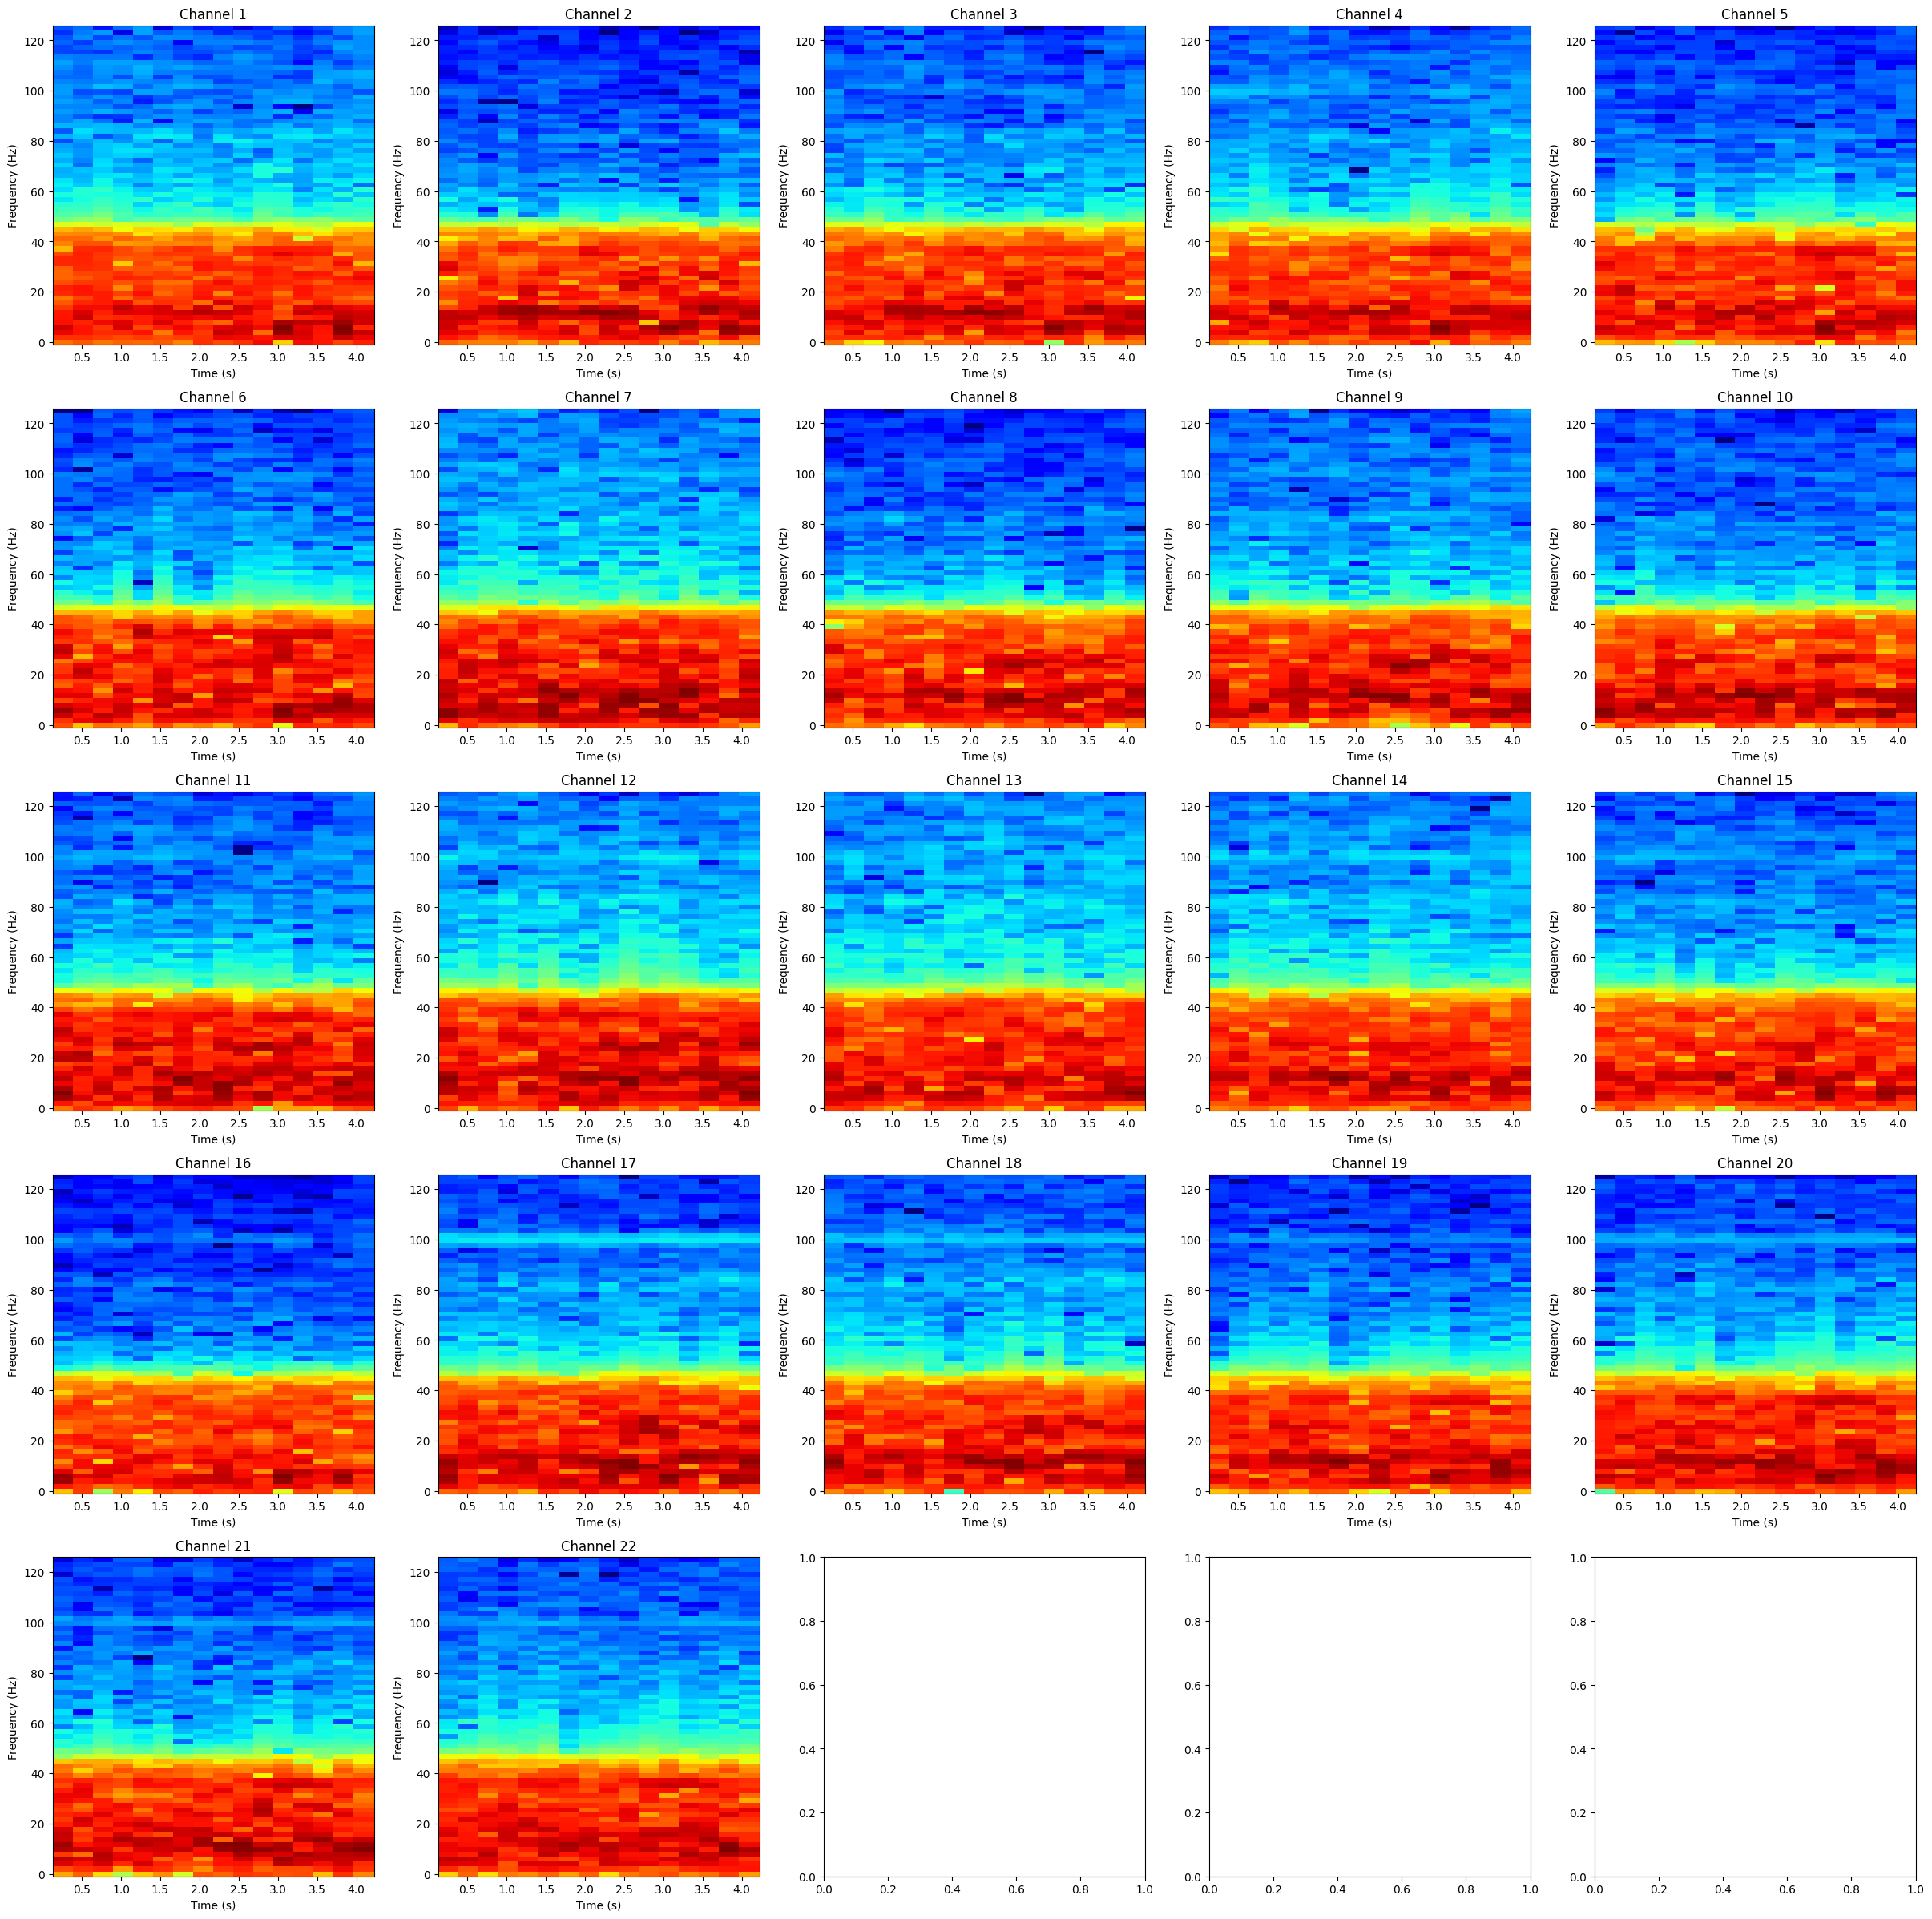

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

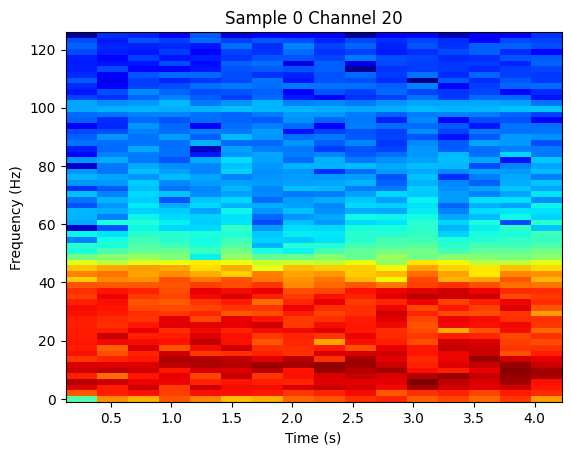

In [4]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][19, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [5]:
spectrograms_spectrogram = []

for i in range(fake_X_.shape[0]):
    f, t, spectrogram = signal.spectrogram(fake_X_[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(5184, 22, 65, 16)


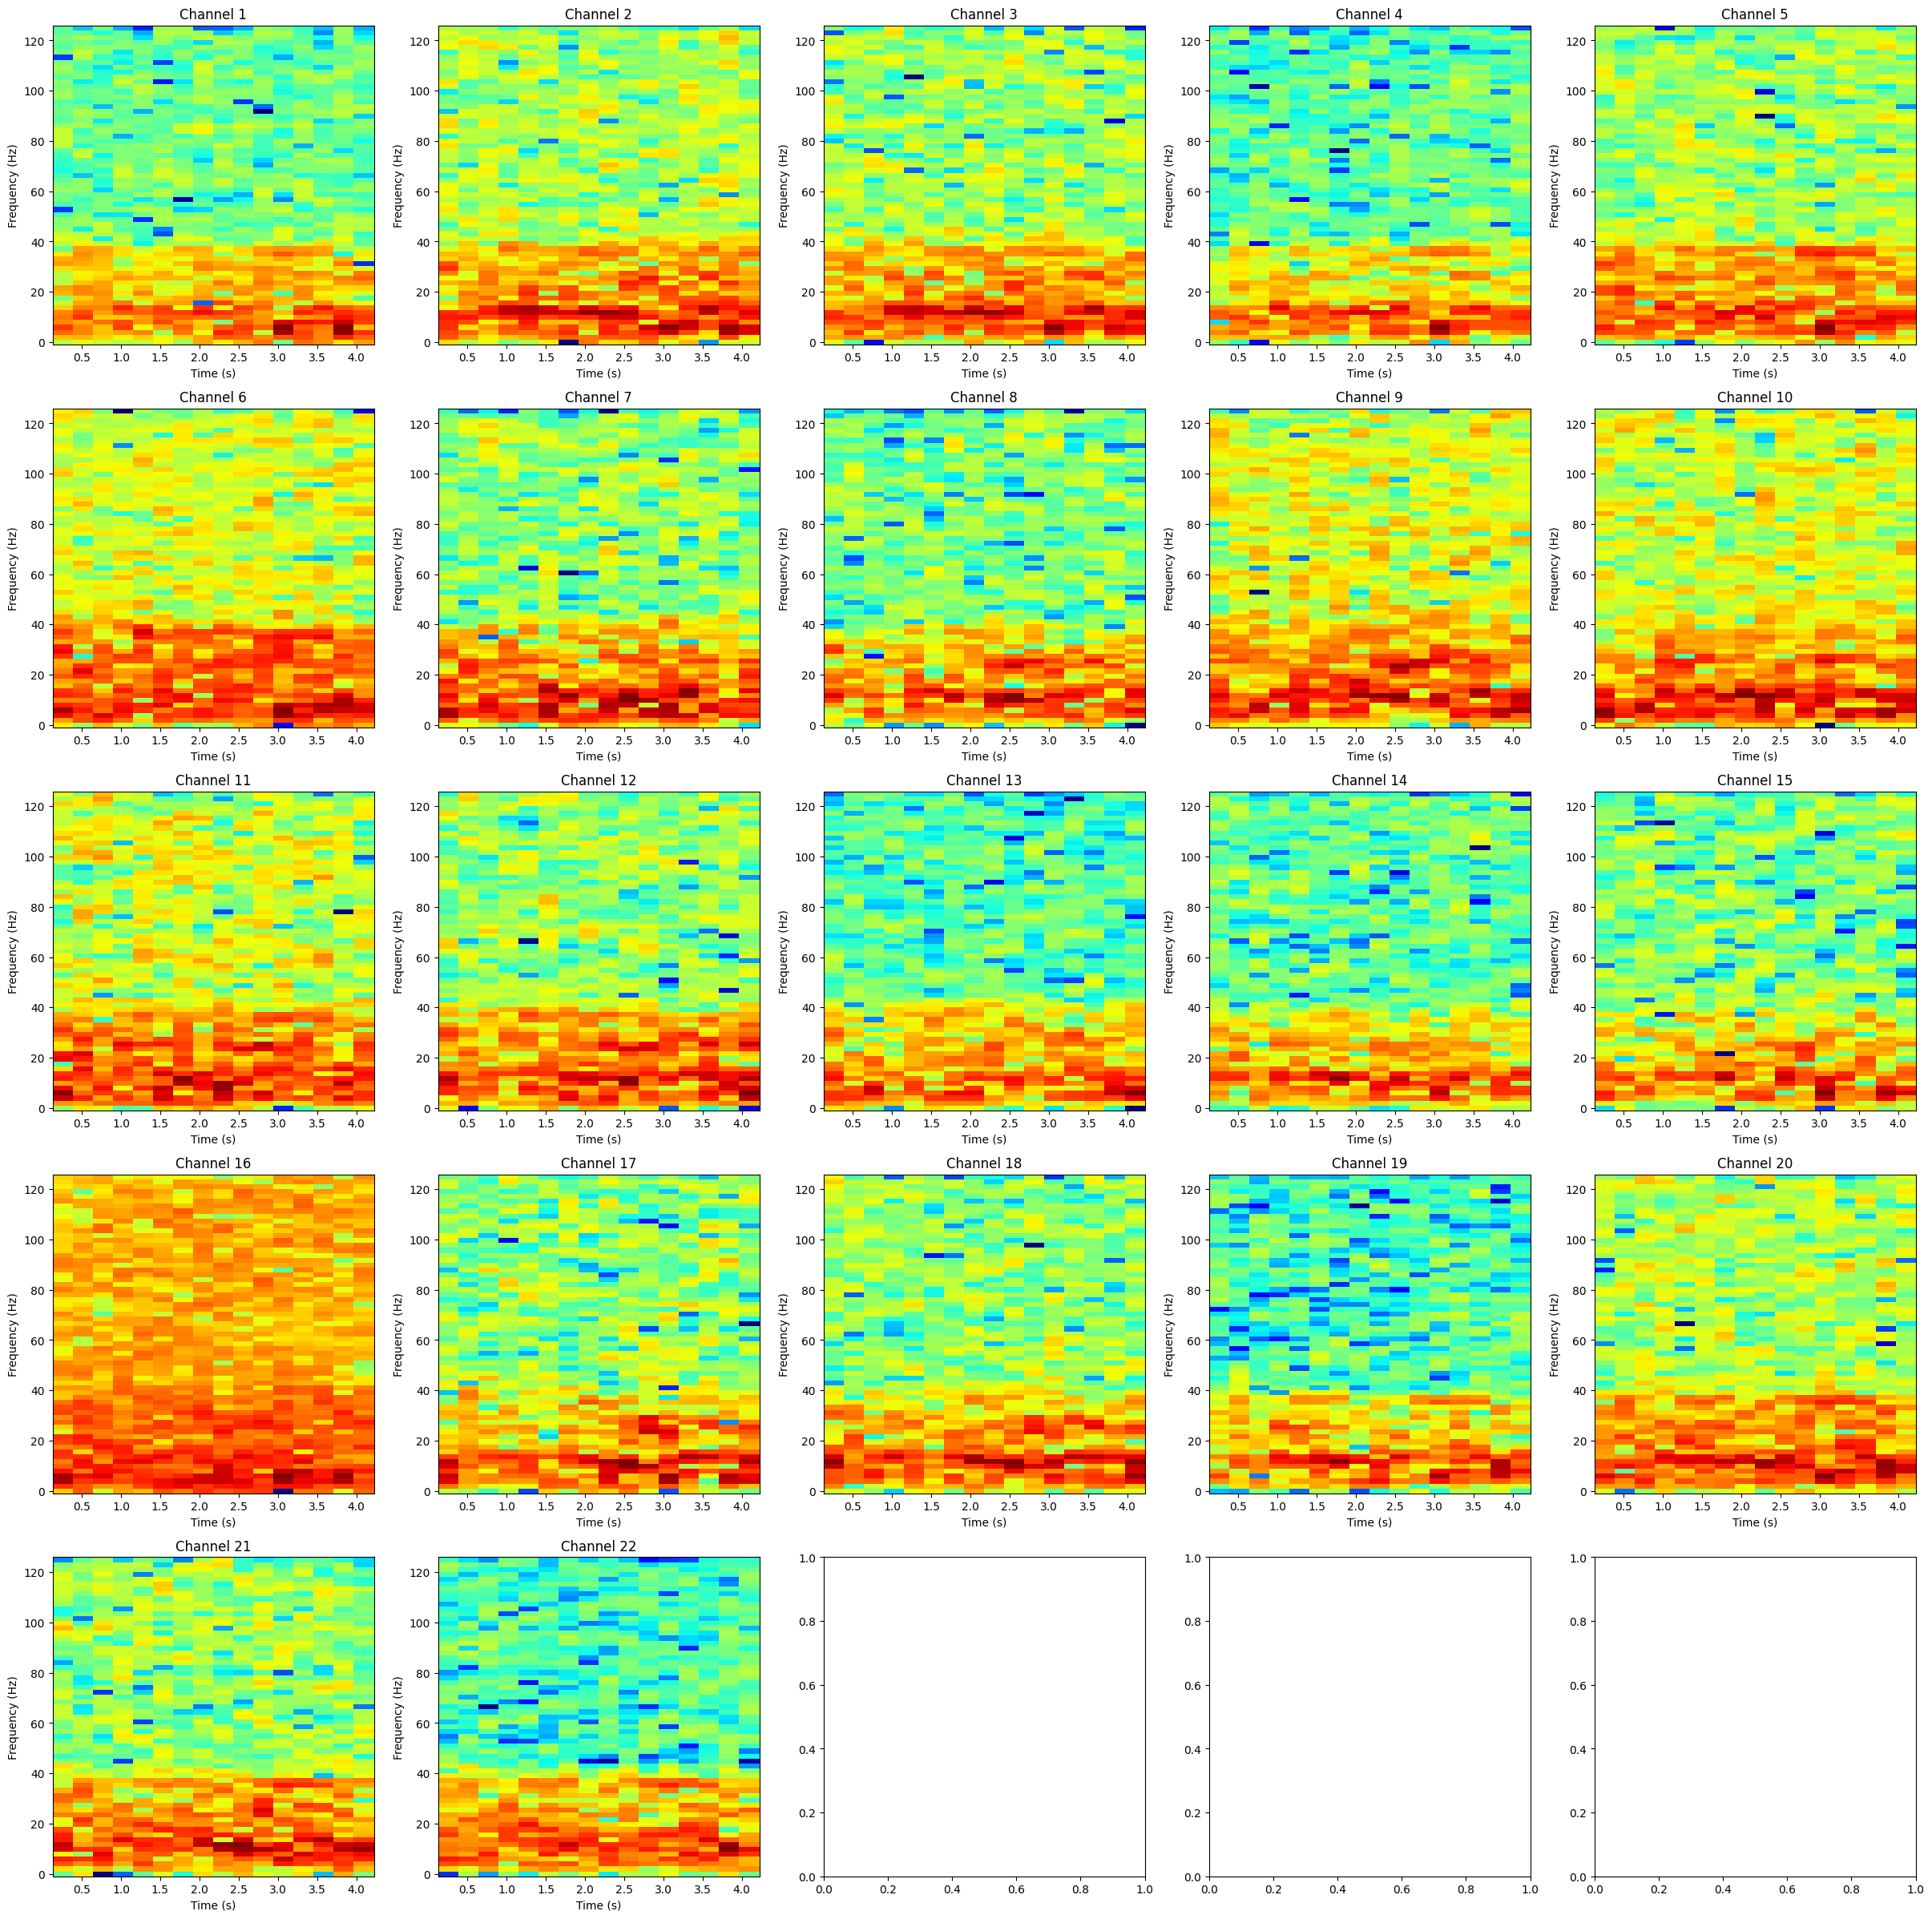

In [6]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

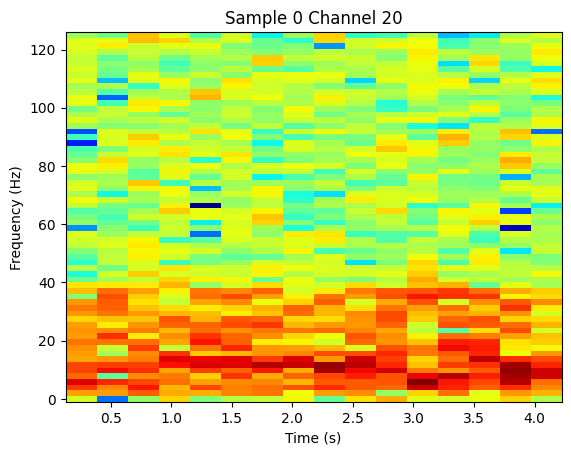

In [7]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][19, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Processamento dos dados sintéticos para classificação

In [6]:
from torch.utils.data import random_split

fake_fulltrainset, fake_evalset = random_split(fake_set, [2592, 2592])
fake_trainset, fake_testset = random_split(fake_fulltrainset, [1728, 864])
real_fulltrainset, real_evalset = random_split(real_set, [2592, 2592])
real_trainset, real_testset = random_split(real_fulltrainset, [1728, 864])

## Definição do modelo do classificador

In [7]:
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = False

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
n_chans = 22
input_window_samples = 1125
F1, D = 4, 2
kernel_length = 64

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    F1=8,
    D=2,
    F2=F1*D,
    kernel_length=kernel_length,
    drop_prob=0.5
)
model.to(device);

## Treinamento do classificador com dados reais

In [8]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

batch_size = 32
n_epochs = 50

real_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(real_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
real_clf.fit(real_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3721        1.4174            0.3426        1.3453  0.0100  1.9726
      2            0.3657        1.3387            0.3356        1.4397  0.0100  0.6510
      3            0.4369        1.2895            0.3993        1.2619  0.0100  0.6532
      4            0.5058        1.2372            0.4248        1.2151  0.0099  0.6513
      5            0.5295        1.2179            0.4815        1.1777  0.0098  0.6528
      6            0.5185        1.1958            0.4525        1.2078  0.0097  0.6539
      7            0.4821        1.1882            0.4595        1.2424  0.0096  0.6540
      8            0.5503        1.1742            0.4954        1.1484  0.0095  0.6580
      9            0.5694        1.1730            0.5012        1.1105  0.0094  0.6599
     10            0.5799       

In [9]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 59.76%


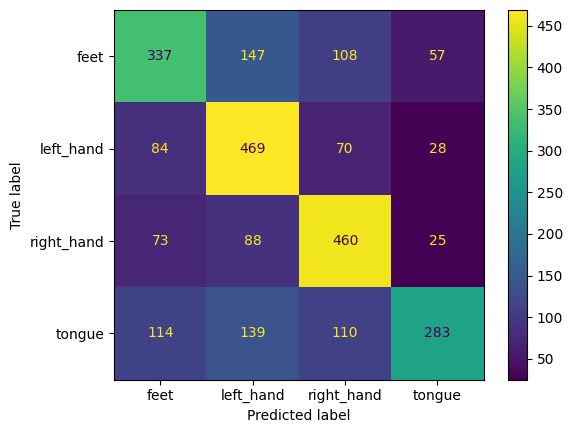

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

trtr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=trtr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [11]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 63.73%


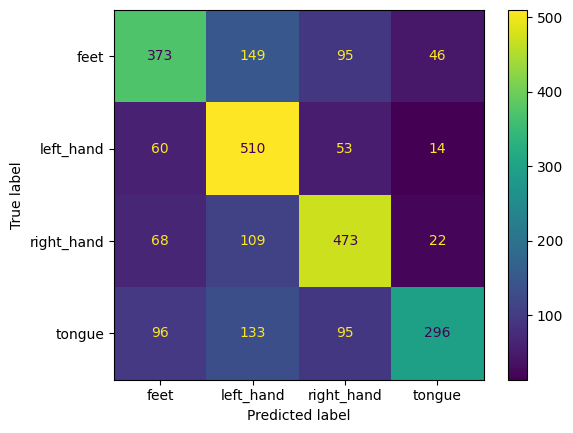

In [12]:
trts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=trts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Treinamento do classificador com dados sintéticos

In [13]:
fake_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(fake_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
fake_clf.fit(fake_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.6146        1.1166            0.5914        0.9639  0.0100  0.6733
      2            0.5966        1.0483            0.5359        1.0076  0.0100  0.6748
      3            0.6730        1.0310            0.6123        0.9305  0.0100  0.6619
      4            0.6568        1.0654            0.5775        1.0011  0.0099  0.6557
      5            0.6065        1.0257            0.5556        1.0356  0.0098  0.6562
      6            0.6528        1.0413            0.5787        0.9814  0.0097  0.6616
      7            0.6429        0.9940            0.5382        1.0079  0.0096  0.6639
      8            0.6684        1.0164            0.5856        0.9909  0.0095  0.6615
      9            0.6667        1.0110            0.5903        0.9770  0.0094  0.6557
     10            0.6771       

In [14]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 66.74%


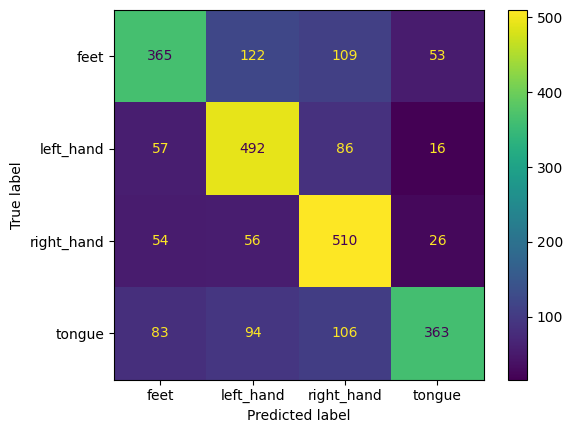

In [15]:
tstr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tstr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [16]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 63.43%


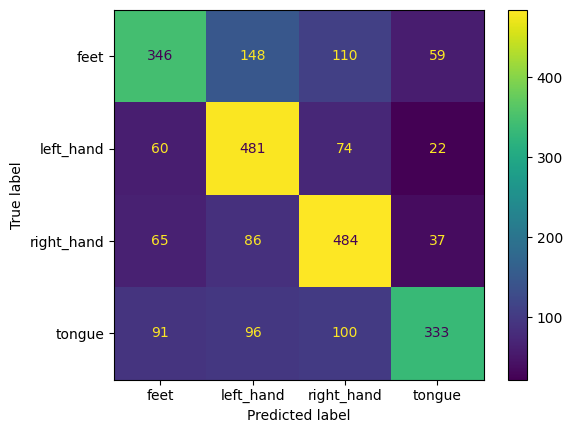

In [17]:
tsts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Distância euclidiana entre os dados reais e sintéticos

In [11]:
size=(22, 1125)
real = X_.view(-1, *size)
fake = fake_X_.view(-1, *size)

In [12]:
torch.norm(real-fake, 2)

tensor(11171.8955)